In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
import imp
import halo_v2
imp.reload(halo_v2)
from halo_v2 import TotalHalo

def unp_to_columns(table,uarray,label,dtype='float'):
    data = [uarray[i].nominal_value for i in range(len(uarray))]
    uncertainties = [uarray[i].std_dev for i in range(len(uarray))]
    table[label] = data
    table['delta_{}'.format(label)] = uncertainties
    return None

def get_halo_table(halo,r_d=[2]):

    halo_table = Table()
    # General masses + sizes
    _ = unp_to_columns(halo_table,halo.M_disc + halo.M_hi,'M_disc')
    _ = unp_to_columns(halo_table,halo.M_bulge,'M_bulge')
    _ = unp_to_columns(halo_table,halo.M_halo(),'M_halo')

    _ = unp_to_columns(halo_table,halo.baryonic_scalelength(),'R_disc')
    _ = unp_to_columns(halo_table,halo.R_bulge,'R_bulge')
    _ = unp_to_columns(halo_table,halo.R_halo()[0],'R_halo')
    
    # ancillary halo data
    _ = unp_to_columns(halo_table,halo.R_halo()[1],'R200')
    _ = unp_to_columns(halo_table,halo.burkert_rho0(),'rho0')
    _ = unp_to_columns(halo_table,halo.M_halo_hernquist(),'M_h_hernquist')
    
    # Masses + sizes w/i 2.2R_d
    _ = unp_to_columns(halo_table,halo.disc_mass_22(),'M_disc_2.2')
    _ = unp_to_columns(halo_table,halo.bulge_mass_22(),'M_bulge_2.2')
    _ = unp_to_columns(halo_table,halo.hernquist_mass_22(),
                       'M_hernquist_2.2')
    _ = unp_to_columns(halo_table,halo.burkert_mass_22(),
                       'M_burkert_2.2')
    
    # Mass fractions:
    _ = unp_to_columns(halo_table,halo.bulge_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.hernquist_mass_22()),'f_b_hernquist')
    
    _ = unp_to_columns(halo_table,halo.bulge_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.burkert_mass_22()),'f_b_burkert')
    
    _ = unp_to_columns(halo_table,halo.disc_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.hernquist_mass_22()),'f_d_hernquist')
    
    _ = unp_to_columns(halo_table,halo.disc_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.burkert_mass_22()),'f_d_burkert')
    
    _ = unp_to_columns(halo_table,halo.hernquist_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.hernquist_mass_22()),'f_h_hernquist')
    
    _ = unp_to_columns(halo_table,halo.burkert_mass_22()
                       /(halo.bulge_mass_22()
                       + halo.disc_mass_22()
                       + halo.burkert_mass_22()),'f_h_burkert')
    
    
    
    for r in r_d:
        # arm numbers 
        _ = unp_to_columns(halo_table,halo.bulge_arm_number(),'m_bulge')
        halo_table['m_disc'] = halo.disc_arm_number()
        _ = unp_to_columns(halo_table,halo.hernquist_arm_number(),
                           'm_hernquist')
        _ = unp_to_columns(halo_table,halo.burkert_arm_number(),'m_burkert')
        
        _ = unp_to_columns(halo_table,halo.bulge_arm_number()
                          + halo.disc_arm_number()
                          + halo.hernquist_arm_number(),'m_total_hernquist')
        
        _ = unp_to_columns(halo_table,halo.bulge_arm_number()
                          + halo.disc_arm_number()
                          + halo.burkert_arm_number(),'m_total_burkert')
        
        # shear
        _ = unp_to_columns(halo_table,halo.total_shear(halo='hernquist'),
                           'Gamma_hernquist')
        _ = unp_to_columns(halo_table,halo.total_shear(halo='burkert'),
                           'Gamma_burkert')
        # pitch angles
        _ = unp_to_columns(halo_table,halo.pitch_angle(halo='hernquist'),
                           'psi_hernquist')
        _ = unp_to_columns(halo_table,halo.pitch_angle(halo='burkert'),
                           'psi_burkert')
        
    return halo_table

In [3]:
'''
# test galaxy (MW)
import imp
import halo_modified
imp.reload(halo_modified)
from halo_modified import TotalHalo, get_halo_table
import astropy.units as u

Md = [10**10.7] * u.Msun
delta_Md = [0] * u.Msun

Rd = [2.2] * u.kpc
delta_Rd = [0.1] * u.kpc

Mb = [10**9.6] * u.Msun
delta_Mb = [0] * u.Msun

Rb = [0.6] * u.kpc
delta_Rb = [0] * u.kpc

Mhi = [0] * u.Msun
delta_Mhi = [0] * u.Msun

mw_halo = TotalHalo(Mb,delta_Mb,Md,delta_Md,Rb,delta_Rb,Rd,delta_Rd,
                    Mhi,delta_Mhi)

mw_halo.total_shear()[0].uncertainty.array
'''

'\n# test galaxy (MW)\nimport imp\nimport halo_modified\nimp.reload(halo_modified)\nfrom halo_modified import TotalHalo, get_halo_table\nimport astropy.units as u\n\nMd = [10**10.7] * u.Msun\ndelta_Md = [0] * u.Msun\n\nRd = [2.2] * u.kpc\ndelta_Rd = [0.1] * u.kpc\n\nMb = [10**9.6] * u.Msun\ndelta_Mb = [0] * u.Msun\n\nRb = [0.6] * u.kpc\ndelta_Rb = [0] * u.kpc\n\nMhi = [0] * u.Msun\ndelta_Mhi = [0] * u.Msun\n\nmw_halo = TotalHalo(Mb,delta_Mb,Md,delta_Md,Rb,delta_Rb,Rd,delta_Rd,\n                    Mhi,delta_Mhi)\n\nmw_halo.total_shear()[0].uncertainty.array\n'

#### Load the relevant data

In [4]:
# SDSS + GZ2
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')
sdss_morph = Table.read('fits/morph_data.fits')
sdss_structure = Table.read('fits/structure_data.fits')
sdss_hi = Table.read('fits/hi_data.fits')
masks = Table.read('fits/masks.fits')

In [5]:
# S4G
s4g_galaxy = Table.read('s4g_fits/galaxy_data.fits')
s4g_structure = Table.read('s4g_fits/bulge_disc_matched.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')
s4g_psi = Table.read('s4g_fits/psi_matched.fits')

#### Sample selection for S4G

In [6]:
# Morphological selection of unbarred S4G galaxies (Buta+)
has_arms = np.any([s4g_morph['AC'] == b'G',s4g_morph['AC'] == b'M',
                   s4g_morph['AC'] == b'F'],axis=0)

morph_ok = np.all([s4g_morph['__T_'] >= 1,
                   s4g_morph['__T_'] <= 9],axis=0)

has_arms = np.any([s4g_morph['AC'] == b'G',s4g_morph['AC'] == b'M',
                   s4g_morph['AC'] == b'F'],axis=0)
unbarred = s4g_morph['__F_'] <= 0.25

# Type decompositions: only select galaxies with a clear disc
acceptable_types = ('bd','bdbar','bdbarf','dbar','dbarf',
                    'dn','bdbarfn','dbarfn','dbarn','dbarnf')
type_ok = np.any([s4g_structure['model'] == type_ 
                  for type_ in acceptable_types],axis=0)

bulge_disc_ok = (s4g_structure['f_bulge'] 
               + s4g_structure['f_disc']) >= 0.9
# ^ only selecting the disc galaxies
fit_ok = s4g_structure['quality'] == '5' # good fits only
disc_ok = s4g_structure['R_d'] > 0

# General catalogue properties
has_mass = np.isfinite(s4g_galaxy['m_tot'])

has_psi = s4g_psi['P_abs'] > 0

s4g_sample = np.all([morph_ok,has_arms,
                     type_ok,bulge_disc_ok,fit_ok,
                     has_mass,disc_ok],axis=0)
s4g_unbarred = np.all([s4g_sample,unbarred],axis=0)
print('{}/{} galaxies with bulge+disc'.format(s4g_sample.sum(),
                                              len(s4g_sample)))
print('+ {} are unbarred'.format(s4g_unbarred.sum()))

s4g_masks = Table()
s4g_masks['spiral_ok'] = s4g_sample
s4g_masks['spiral_unbarred'] = s4g_unbarred
s4g_masks.write('s4g_fits/s4g_masks.fits',overwrite=True)

204/2352 galaxies with bulge+disc
+ 101 are unbarred


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


In [7]:
# S4G galaxies ...

m_tot = s4g_galaxy['m_tot'][s4g_sample] * u.Msun
delta_m_tot = s4g_galaxy['delta_m_tot'][s4g_sample] * u.Msun

m_b = s4g_structure['f_bulge'][s4g_sample].data * m_tot
m_b[m_b < 0] = 0
delta_m_b = s4g_structure['f_bulge'][s4g_sample].data * delta_m_tot
delta_m_b[delta_m_b < 0] = 0

m_d = s4g_structure['f_disc'][s4g_sample].data * m_tot
m_d[m_d < 0] = 0
delta_m_d = s4g_structure['f_disc'][s4g_sample].data * delta_m_tot
delta_m_d[delta_m_d < 0] = 0

a_b = s4g_structure['R_b'][s4g_sample].data * u.kpc
a_b[a_b < 0] = 0
delta_a_b = s4g_structure['delta_R_b'][s4g_sample].data * u.kpc
delta_a_b[a_b < 0] = 0

R_d = s4g_structure['R_d'][s4g_sample].data * u.kpc
R_d[R_d < 0] = 0
delta_R_d = s4g_structure['delta_R_d'][s4g_sample].data * u.kpc
R_d[delta_R_d < 0] = 0

m_hi = 0 * u.Msun
delta_m_hi = 0 * u.Msun


s4g_halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,
                      a_b,delta_a_b,R_d,delta_R_d,
                      m_hi,delta_m_hi,scale=1,scale_error=0)

In [8]:
# Sloan galaxies ...
sample_ok = masks['z<0.085 (unbarred spiral)']
# only do 200 to save time for now...
#sample_adjust = np.argwhere(sample_ok == True)[200:]
#sample_ok[sample_adjust] = False

m_b = sdss_structure['m_b'][sample_ok].data * u.Msun
delta_m_b = sdss_structure['delta_m_b'][sample_ok].data * u.Msun
# Remove gals. with small poorly fit bulges
no_bulge = sdss_structure[sample_ok]['Type'] == 2
m_b[no_bulge] = 0 * u.Msun
delta_m_b[no_bulge] = 0* u.Msun

m_d = sdss_structure['m_d'][sample_ok].data * u.Msun
delta_m_d = sdss_structure['delta_m_d'][sample_ok].data * u.Msun

a_b = sdss_structure['R_b'][sample_ok].data * u.kpc
delta_a_b = sdss_structure['delta_R_b'][sample_ok].data * u.kpc

R_d = sdss_structure['R_d'][sample_ok].data * u.kpc
delta_R_d = sdss_structure['delta_R_d'][sample_ok].data * u.kpc

m_hi = sdss_hi['hi_mass'][sample_ok].data * u.Msun
delta_m_hi = sdss_hi['hi_mass_error'][sample_ok].data * u.Msun
#fig, axarr = plt.subplots(2,4,figsize=(20,10))

sdss_halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,
                       a_b,delta_a_b,R_d,delta_R_d, 
                       0*u.Msun,0*u.Msun,scale=1.5,scale_error=0.2)

sdss_w_gas = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,
                        a_b,delta_a_b,R_d,delta_R_d,
                        m_hi,delta_m_hi,scale=1.5,scale_error=0.2)

In this notebook, we now have four different haloes to compare:

* SDSS stellar
* SDSS stellar+gas discs
* S4G
* Milky Way

In [9]:
s4g_halo_table = get_halo_table(s4g_halos)
sdss_halo_table = get_halo_table(sdss_halos)
sdss_w_gas_table = get_halo_table(sdss_w_gas)

#### Final task is to append the half light radius

In [10]:
from sersic import sersic_enc_lum_linear as M_enclosed, sersic_Ie as Ie 

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def half_light_radius(Mb,Rb,Md,Rd):

    rs = np.linspace(0.1,20,200)
    mass_enclosed = []
    Ie_bulge = Ie(Mb,Rb,4)
    Ie_disc = Ie(Md,Rd,1)
    M_total = Mb + Md
    for r in rs:
        mass_enclosed.append(M_enclosed(r,Ie_bulge,Rb,4) 
                           + M_enclosed(r,Ie_disc,Rd,1))
        
    i = find_nearest(np.array(mass_enclosed),M_total/2)
    half_light_radius = rs[i]
    return half_light_radius

def calculate_r_half(table):
    Mb = table['M_bulge']
    Md = table['M_disc']
    Rb = table['R_bulge'] * (1+math.sqrt(2))
    Rd = table['R_disc'] * 1.678
    r_half = []
    for mb, md, rb, rd in zip(Mb,Md,Rb,Rd):
        r_half.append(half_light_radius(mb,rb,md,rd))
        
    return r_half

In [11]:
# S4G ...
s4g_halo_table['r_half'] = calculate_r_half(s4g_halo_table)
# SDSS ...
sdss_halo_table['r_half'] = calculate_r_half(sdss_halo_table)
# SDSS + HI...
sdss_w_gas_table['r_half'] = calculate_r_half(sdss_w_gas_table)

../astro_codes/sersic.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  Ie = M / (re**2*(2*pi*n) * exp(bn)/bn**(2*n) * gamma(2*n))
../astro_codes/sersic.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  x = b(n) * (r/re)**(1.0/n)
../astro_codes/sersic.py:41: RuntimeWarning: invalid value encountered in double_scalars
  return Ie * re**2 * 2*pi*n * exp(bn)/(bn**(2*n)) * g2n


In [12]:
def match_tables(match_table,halo_table,mask,id_column):
    matched_table = Table()
    for c in halo_table.colnames:
        matched_table[c] = np.full(len(match_table),-999,dtype='float64')
        matched_table[c][mask] = halo_table[c]
    
    matched_table['id'] = match_table[id_column]
    matched_table['mask'] = mask
    return matched_table

sdss_halo_table_matched = match_tables(gz2_data,sdss_halo_table,
                                       sample_ok,'dr7objid')
sdss_w_gas_table_matched = match_tables(gz2_data,sdss_w_gas_table,
                                        sample_ok,'dr7objid')
s4g_halo_table_matched = match_tables(s4g_galaxy,s4g_halo_table,s4g_sample,
                                'object')
s4g_halo_table_matched['unbarred_sample'] = s4g_unbarred

In [13]:
sdss_halo_table.write('fits/sdss_halo_table.fits',overwrite=True)
sdss_w_gas_table.write('fits/sdss_w_gas_table.fits',overwrite=True)
s4g_halo_table.write('fits/s4g_halo_table.fits',overwrite=True)

sdss_halo_table_matched.write('fits/sdss_halo_table_matched.fits',
                              overwrite=True)
sdss_w_gas_table_matched.write('fits/sdss_w_gas_table_matched.fits',
                               overwrite=True)
s4g_halo_table_matched.write('fits/s4g_halo_table_matched.fits',
                             overwrite=True)

(array([  9.36000000e+02,   2.49100000e+03,   2.03000000e+03,
          1.38000000e+03,   6.17000000e+02,   1.12000000e+02,
          2.10000000e+01,   1.50000000e+01,   4.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.03437585,  0.32752981,  0.62068378,  0.91383774,  1.2069917 ,
         1.50014566,  1.79329962,  2.08645359,  2.37960755,  2.67276151,
         2.96591547,  3.25906943,  3.5522234 ,  3.84537736,  4.13853132,
         4.43168528,  4.72483924,  5.01799321,  5.31114717,  5.60430113,
         5.89745509,  6.19060905,  6.48376301,  6.77691698,  7.07007094,
         7.3632249 ]),
 <a list of 25 Patch objects>)

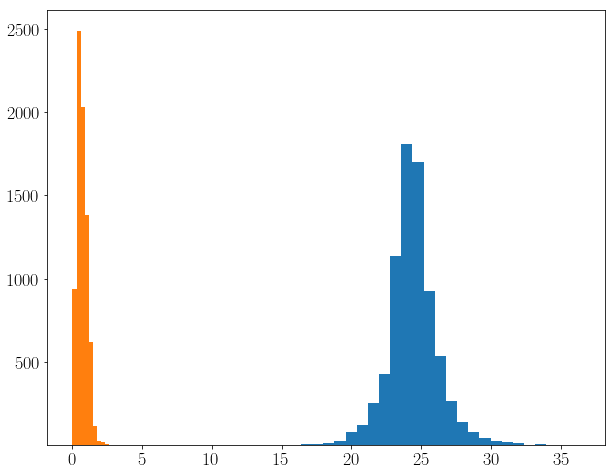

In [14]:
plt.hist(sdss_halo_table['psi_hernquist'],bins=25)
plt.hist(sdss_halo_table['delta_psi_hernquist'],bins=25)